# Time-Domain Simulation and Plotting

## Run Time-Domain Simulation

In [1]:
import andes

from andes.utils.paths import get_case

### Run power flow by default

In [2]:
ss = andes.run(get_case('kundur/kundur_full.xlsx'))

Parsing input file </Users/hcui7/repos/andes/andes/cases/kundur/kundur_full.xlsx>
Input file kundur_full.xlsx parsed in 0.0618 second.
-> Power flow calculation with Newton Raphson method:
Power flow initialized.
0: |F(x)| = 14.9283   
1: |F(x)| = 3.60859   
2: |F(x)| = 0.170093  
3: |F(x)| = 0.00203827
4: |F(x)| = 3.76414e-07
Converged in 5 iterations in 0.0106 second.
Report saved to </Users/hcui7/repos/andes/examples/kundur_full_out.txt> in 0.0010 second.
-> Single process finished in 0.1176 second.


### Run time-domain simulation 
Run TDS by calling `TDS.run()` on the system. Note that the call must follow the power flow immediately.

The default simulation is for 20 seconds. To change if, change ``config.tf`` to the desired value.

In [3]:
ss.TDS.config.tf = 10  # simulate for 10 seconds

In [4]:
ss.TDS.run()

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-10s
Fixed step size: h=0.03333s
Initialization successful in 0.0173 second.


<Toggle 0>: Status of Line.Line_8 changed to 0.0.                     
100%|████████████████████████████████| 100/100 [00:01<00:00, 89.07%/s]

Simulation completed in 1.1231 seconds.
TDS outputs saved in 0.0196 second.


## Plot Results

A `Plotter` object is created for `TDS`. It uses the same API as the command-line plot.

`plotter.plot()` is a method for plotting. 

### Index lookup

Before plotting, open the `kundur_full_out.lst` to find the indices (first column) for the variables to plot.

For example, if we want to plot all generator speed, which is the `omega` variable of `GENROU`. 
From inspect, we know the indices are `2, 8, 14, 20`. Pass them in a tuple to `plotter.plot`.

Using LaTeX for rendering.
If the rendering takes too long or an error occurs:
a) If you are using `andes plot`, disable with optino "-d",
b) If you are using `plot()`, set "latex=False".


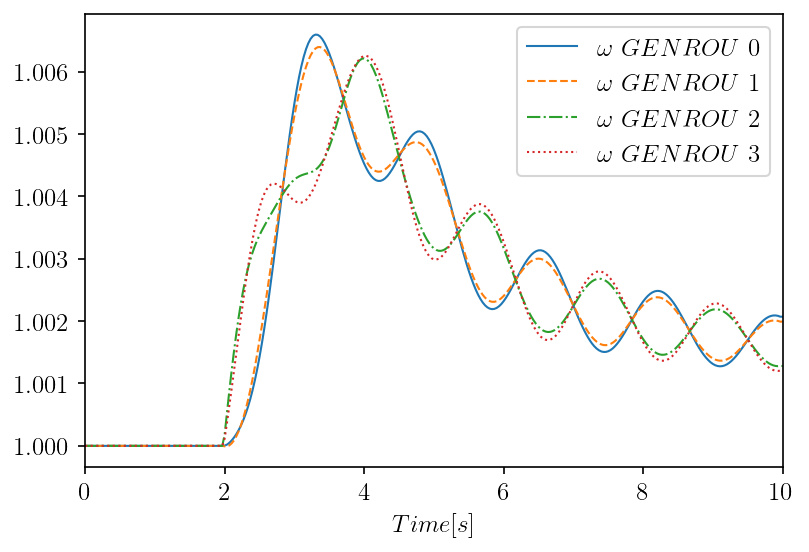

In [5]:
fig, ax = ss.TDS.plotter.plot((2, 8, 14, 20))

### Find index by variable name

`plotter.find()` is a method for finding indices based on variable name.

The first argument is the pattern to find. An optional argument `exclude` is the pattern to exclude. Regular expression is supported for both.

In [6]:
ss.TDS.plotter.find('omega')

([2, 8, 14, 20],
 ['GENROU omega 0', 'GENROU omega 1', 'GENROU omega 2', 'GENROU omega 3'])

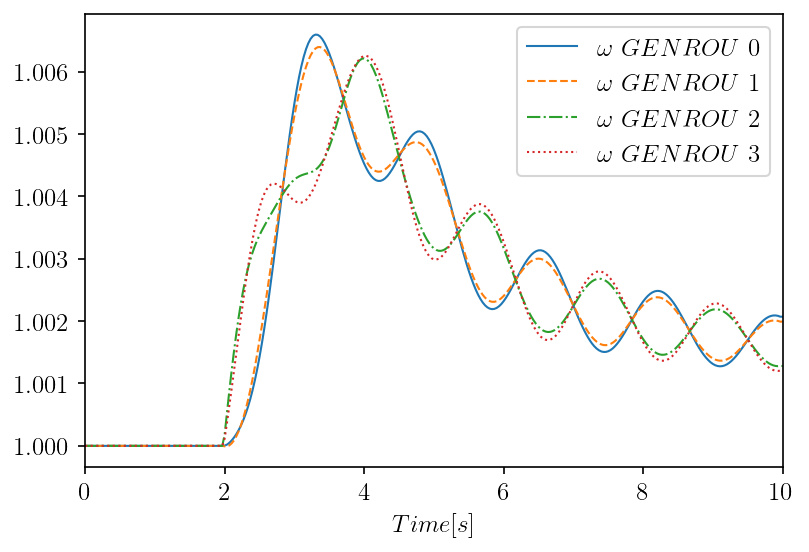

In [7]:
fig, ax = ss.TDS.plotter.plot(ss.TDS.plotter.find('omega')[0])

### Y-axis label

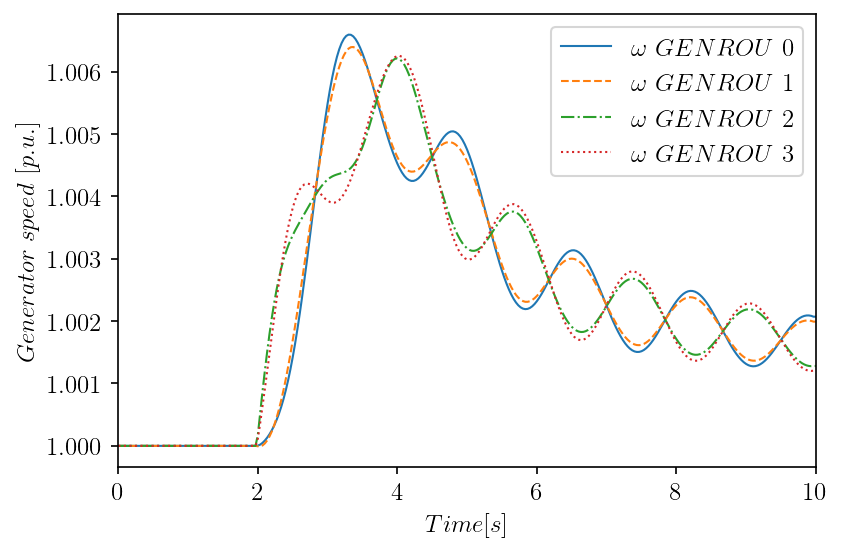

In [8]:
fig, ax = ss.TDS.plotter.plot((2, 8, 14, 20), ylabel='Generator speed [p.u.]')

### Scaling

A lambda functino can be passed to `ycalc` to scale the value. To scale the frequency from per unit to 60 Hz nominal values, use

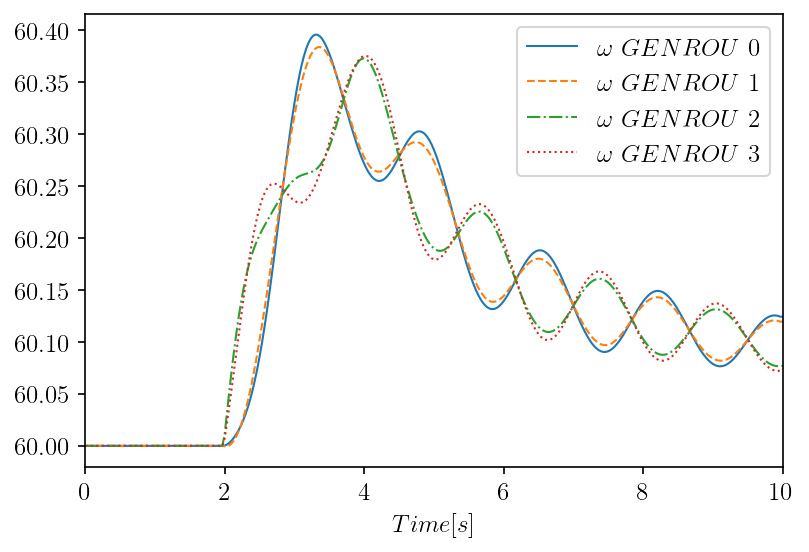

In [9]:
fig, ax = ss.TDS.plotter.plot((2, 8, 14, 20), ycalc=lambda x: 60 * x)

### Greyscale and Grid

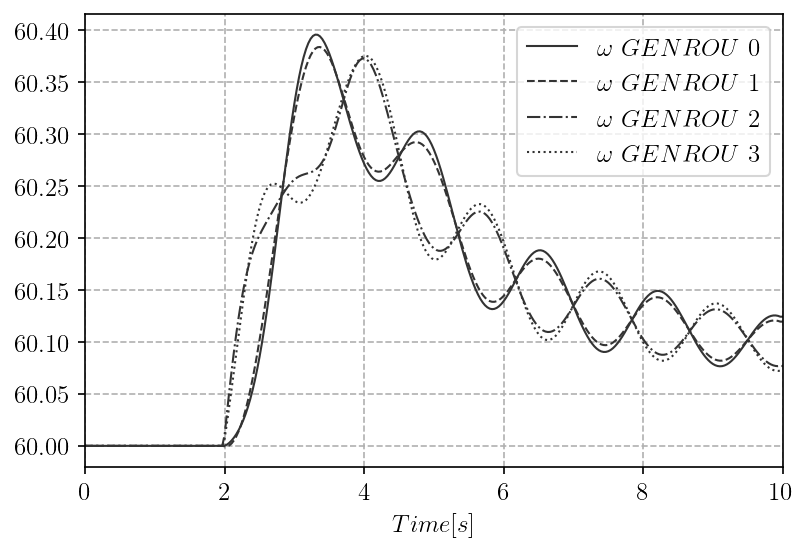

In [10]:
fig, ax = ss.TDS.plotter.plot((2, 8, 14, 20),
                              ycalc=lambda x: 60 * x,
                             greyscale=True,
                             grid=True)

### Save figure

Pass `savefig = True` to save the figure to a `png` file. 

Figure saved to <kundur_full_1.png>


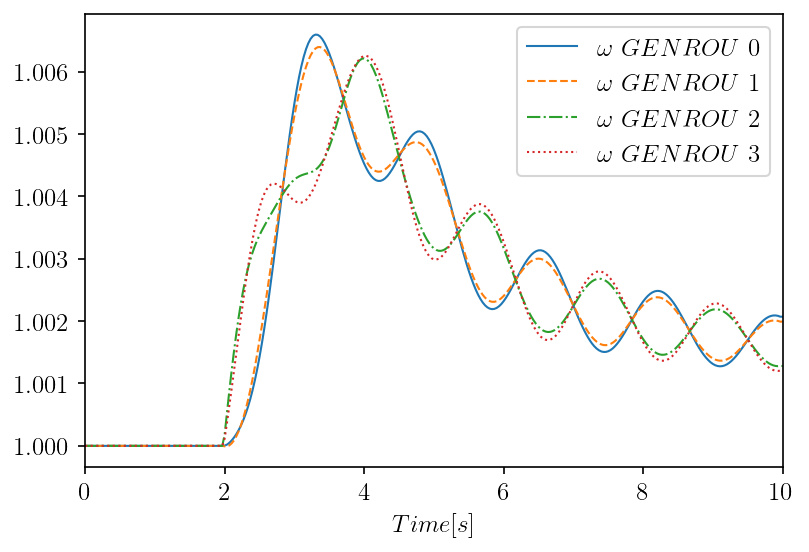

In [11]:
fig, ax = ss.TDS.plotter.plot([2, 8, 14, 20], savefig=True)

### Additional arguments

`plotter.plot` takes addition arguments. To check additional arguments, please use `help` or refer to the source code.

In [12]:
help(ss.TDS.plotter.plot)

Help on method plot in module andes.plot:

plot(yidx, xidx=(0,), a=None, ycalc=None, left=None, right=None, ymin=None, ymax=None, ytimes=None, xlabel=None, ylabel=None, legend=True, grid=False, latex=True, dpi=150, savefig=None, show=True, use_bqplot=False, **kwargs) method of andes.plot.TDSData instance
    Entery function for plot scripting. This function retrieves the x and y values based
    on the `xidx` and `yidx` inputs and then calls `plot_data()` to do the actual plotting.
    
    Note that `ytimes` and `ycalc` are applied sequentially if apply.
    
    Refer to `plot_data()` for the definition of arguments.
    
    Parameters
    ----------
    xidx : list or int
        The index for the x-axis variable
    
    yidx : list or int
        The indices for the y-axis variables
    
    Returns
    -------
    (fig, ax)
        Figure and axis handles



## Cleanup

In [14]:
! andes misc -C

ANDES 0.8.3 (Git commit id 1137236a, Python 3.7.1 on Darwin)
Session: hcui7, 04/02/2020 06:06:06 PM
This program comes with ABSOLUTELY NO WARRANTY.

<kundur_full_out.txt> removed.
<kundur_full_eig.txt> removed.
<kundur_full_out.npy> removed.
<kundur_full_out.lst> removed.
